In [2697]:
import sys
!{sys.executable} -m pip install fpdf -q
!{sys.executable} -m pip install pandas -q
!{sys.executable} -m pip install geopandas geopy
!{sys.executable} -m pip install plotly-express -q
!{sys.executable} -m pip install kaleido -q
!{sys.executable} -m pip install geopy -q

In [2667]:
from datetime import date
from pathlib import Path
from geopy.geocoders import Nominatim
import sqlite3
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px  
from fpdf import FPDF  

In [2436]:
plotly_template = "presentation"

In [2437]:
from pathlib import Path
base_dir = Path("/Users/admin")
output_dir = base_dir / "output"
output_dir.mkdir(parents=True, exist_ok=True)

In [2438]:
conn = sqlite3.connect("/Users/admin/Desktop/ProcurementContactDatabase.db")

In [2444]:
query = '''
SELECT COUNT(supplier_id) AS total_suppliers
FROM suppliers
'''

df = pd.read_sql_query(query,conn)


In [2446]:
print(df)

   total_suppliers
0               17


In [2448]:
df=df.set_index('total_suppliers')
df.head(3)

""
total_suppliers
17


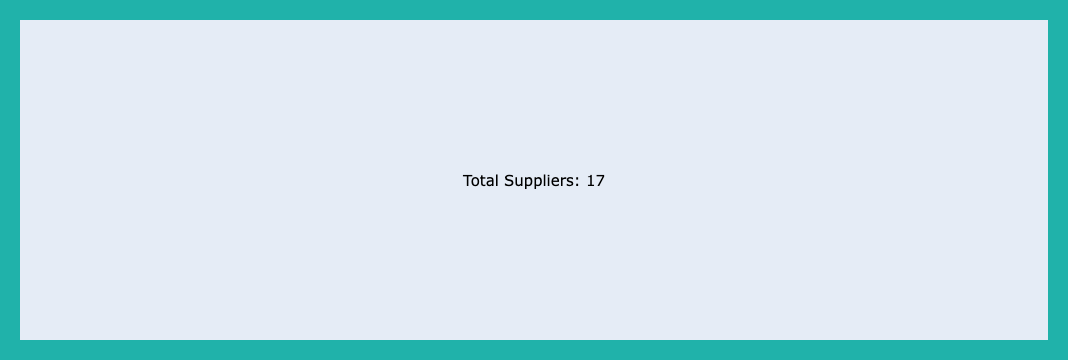

In [2450]:
import plotly.graph_objects as pxo
total_suppliers = 17
fig = pxo.Figure()

fig.add_annotation(
    text=f"Total Suppliers: {total_suppliers}",
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=15, color="black"),
    x=0.5, y=0.5,  
    xanchor='center', yanchor='middle'
)

fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(
    width=200,
    height=100,
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    paper_bgcolor="LightSeaGreen"
)

fig.show()

fig.write_image(output_dir / 'total_suppliers.png',
                width=200,
                height=150,
                scale=4)

In [2847]:
query = '''
SELECT industry, COUNT(industry) AS suppliers
FROM suppliers
GROUP BY industry
ORDER BY suppliers ASC
'''
df = pd.read_sql_query(query,conn)

In [2849]:
print(df)

              industry  suppliers
0       Carbon Capture          1
1     Energy Resources          1
2            Utilities          1
3          Wind Energy          1
4            Batteries          2
5            Bioenergy          2
6    Geothermal Energy          2
7  Hydropower Industry          2
8          Solar Power          2
9      Hydrogen Energy          3


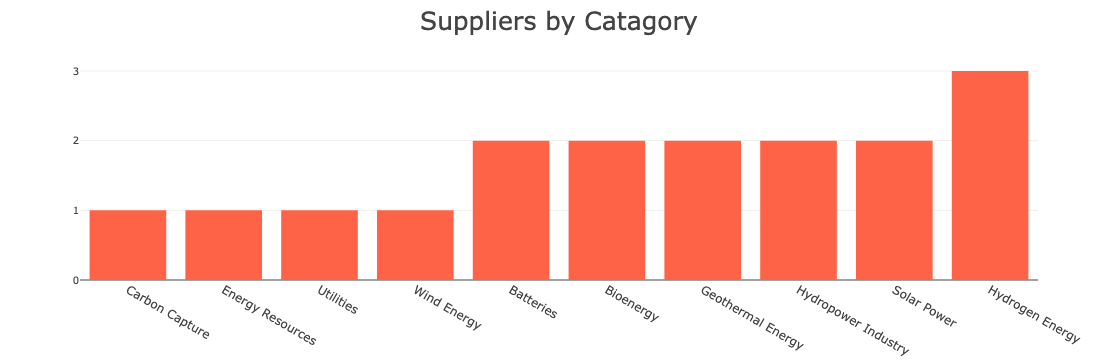

In [2851]:
fig = px.bar(df,
             x='industry',
             y='suppliers',
             template=plotly_template,
             color_discrete_sequence=['Tomato']
            )


fig.update_layout(
    title='Suppliers by Catagory',
    xaxis_title='',
    yaxis_title='',  
    yaxis_tickprefix='',
    xaxis=dict(
        tickfont=dict(size=12),
),
    yaxis=dict(
        tickfont=dict(size=10),     
        tickformat=',d',
        dtick=1 
    )
)

fig.write_image(output_dir / 'Suppliers_by_catagory.png',
                width=900,
                height=300,
                scale=4)
fig.show()

In [2472]:
print(df.columns)

Index(['location', 'industry', 'distribution', 'latitude', 'longitude'], dtype='object')


In [2717]:
query = '''
SELECT location, industry, COUNT(location) AS distribution
FROM suppliers
GROUP BY location
ORDER BY COUNT(location) ASC
'''
df = pd.read_sql_query(query,conn)

In [2719]:
print(df)

    location             industry  distribution
0  Argentina          Solar Power             1
1    Croatia      Hydrogen Energy             1
2     France  Hydropower Industry             1
3    Germany       Carbon Capture             1
4      Italy            Batteries             1
5     Poland      Hydrogen Energy             1
6   Portugal            Bioenergy             1
7     Serbia    Geothermal Energy             1
8      Spain            Utilities             1
9    Austria          Solar Power             8


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


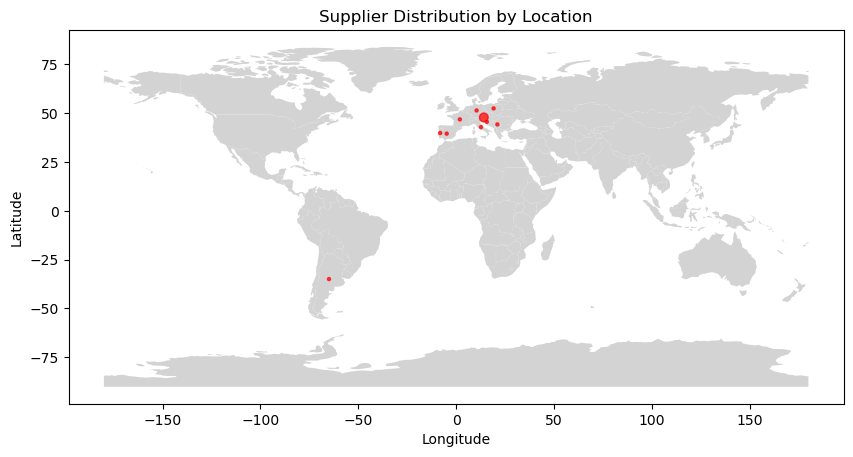

In [2723]:
geolocator = Nominatim(user_agent="geoapiExercises")
def geocode_location(location):
    try:
        location = geolocator.geocode(location)
        return (location.latitude, location.longitude)
    except:
        return None
tqdm.pandas()  
df['coordinates'] = df['location'].progress_apply(geocode_location)

df.dropna(subset=['coordinates'], inplace=True)

df['latitude'] = df['coordinates'].apply(lambda x: x[0])
df['longitude'] = df['coordinates'].apply(lambda x: x[1])

# Step 2: Convert to a GeoPandas DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

# Step 3: Load a world map from Geopandas
world = gpd.read_file('/Users/admin/Downloads/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Step 4: Plot the data
fig, ax = plt.subplots(figsize=(10, 8))
world.plot(ax=ax, color='lightgray')

# Plot the locations of suppliers
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['distribution'] * 5, alpha=0.7)

# Adding titles and labels
plt.title('Supplier Distribution by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

output_path = os.path.join(output_dir, 'distribution_by_location.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [2603]:
query = '''
SELECT p.order_accuracy_percent, s.supplier_name AS supplier_name
FROM performances p
JOIN suppliers s ON p.supplier_id = s.supplier_id
GROUP BY supplier_name
ORDER BY order_accuracy_percent ASC
'''
df = pd.read_sql_query(query,conn)

In [2605]:
df

,order_accuracy_Percent,supplier_name
0,45,Solaria Synergy
1,66,Progression rapide
2,88,Nova energija budućnosti
3,97,PureEarth Erneuerbare Energien
4,98,Planeta Verde
5,98,WindFusion Dynamics
6,99,EcoWave Energy Solutions
7,100,EcoLoom Energy Systems
8,100,Grande terra
9,100,TerraNova-Kraft


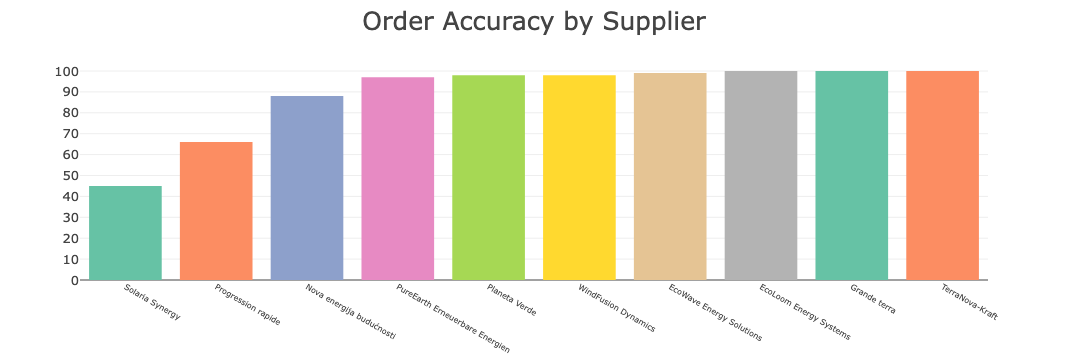

In [2607]:
fig = px.bar(df,
             x='supplier_name',
             y='order_accuracy_Percent',
             template=plotly_template,
             color='supplier_name',
             color_discrete_sequence=px.colors.qualitative.Set2
            )



fig.update_layout(
    title='Order Accuracy by Supplier',
    xaxis_title='',
    yaxis_title='',  
    yaxis_tickprefix='',
    xaxis=dict(
        tickfont=dict(size=8)
),
    yaxis=dict(
        tickfont=dict(size=13),     
        tickformat=',d',
        dtick=10
    ),
showlegend=False
)


fig.show()


fig.write_image(output_dir / 'order_accuracy_by_supplier.png',
                width=1400,
                height=300,
                scale=4)

In [2609]:
query = '''
SELECT c.contract_end_date,
       s.supplier_name,
       s.contact_name,
       s.email,
       s.phone_number
FROM suppliers s
JOIN contracts c ON s.supplier_id = c.supplier_id
WHERE c.contract_end_date LIKE '%2024%'
    AND c.renewal_option_yes_or_no = 'y'
GROUP BY
    c.contract_end_date, 
    s.supplier_name,
    s.contact_name,
    s.email,
    s.phone_number
ORDER BY contract_end_date ASC
'''
df = pd.read_sql_query(query,conn)

In [2611]:
print(df)

  contract_end_date    supplier_name      contact_name  \
0        2024-09-06     Grande terra  Alessandro Ricci   
1        2024-10-14  Solaria Synergy  Elisabeth Koller   

                               email      phone_number  
0     alessandroricci@grandeterra.it   +39 347 1234567  
1  elisabethkoller@solariasynergy.at  +43 676 234 5678  


In [2613]:
df = df.set_index('supplier_name')
df.head(3)

,contract_end_date,contact_name,email,phone_number
supplier_name,,,,
Grande terra,2024-09-06,Alessandro Ricci,alessandroricci@grandeterra.it,+39 347 1234567
Solaria Synergy,2024-10-14,Elisabeth Koller,elisabethkoller@solariasynergy.at,+43 676 234 5678


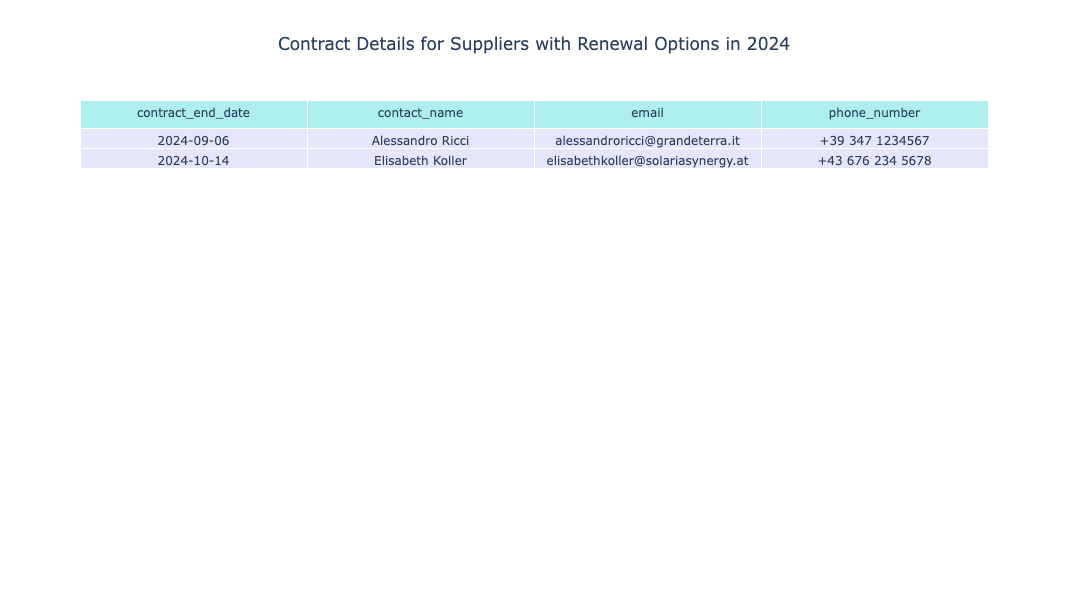

In [2615]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color='lavender',
               align='center',
               height=20)
)])
fig.update_layout(
    title='Contract Details for Suppliers with Renewal Options in 2024',
    title_x=0.5,
    width=1000,
    height=600
)

fig.write_image(output_dir /"contract_data_table.png", 
                width=1000,
                height=250)


fig.show()

In [2785]:
query = '''
SELECT p.quality_score_rating_comments, s.supplier_name AS supplier_name
FROM performances p
JOIN suppliers s ON p.supplier_id = s.supplier_id
GROUP BY supplier_name
ORDER BY 
    CASE 
        WHEN quality_score_rating_comments = 'very poor' THEN -2
        WHEN quality_score_rating_comments = 'poor' THEN -1
        WHEN quality_score_rating_comments = 'good' THEN 1
        WHEN quality_score_rating_comments = 'very good' THEN 2
    END
'''
df = pd.read_sql_query(query,conn)

In [2787]:
print(df)

  quality_score_rating_comments                   supplier_name
0                     very poor              Progression rapide
1                          poor                 Solaria Synergy
2                          poor             WindFusion Dynamics
3                          good        Nova energija budućnosti
4                          good                   Planeta Verde
5                          good  PureEarth Erneuerbare Energien
6                     very good          EcoLoom Energy Systems
7                     very good        EcoWave Energy Solutions
8                     very good                    Grande terra
9                     very good                 TerraNova-Kraft


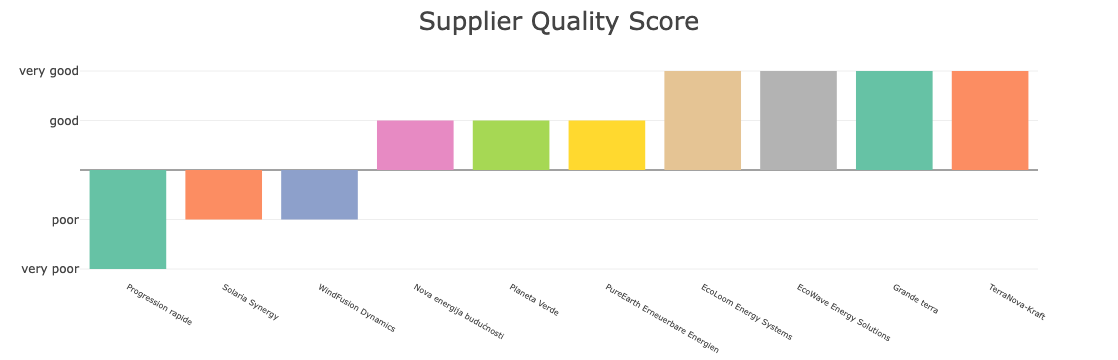

In [2823]:
quality_score_mapping = {
    'very poor': -2,
    'poor': -1,
    'good': 1,
    'very good': 2
}

df['quality_score_numeric'] = df['quality_score_rating_comments'].map(quality_score_mapping)

fig = px.bar(df,
             x='supplier_name',
             y='quality_score_numeric',
             template=plotly_template,
             color='supplier_name',
             color_discrete_sequence=px.colors.qualitative.Set2
            )


fig.update_layout(
    title='Supplier Quality Score',
    xaxis_title='',
    yaxis_title='',  
    yaxis_tickprefix='',
    xaxis=dict(
        tickfont=dict(size=8),
        tickformat=',d',
        dtick=1 
),
    yaxis=dict(
        tickfont=dict(size=12),       
        tickformat=',d',
        dtick=1 
    ),
showlegend=False
)
y_labels = ['very poor', 'poor', 'good', 'very good']
fig.update_yaxes(tickvals=[-2, -1, 1, 2], ticktext=y_labels)


fig.show()


fig.write_image(output_dir / 'suppliers_quality_score.png',
                width=1200,
                height=400,
                scale=5)

In [2853]:
font_color = (64, 64, 64)

chart_filenames = [str(chart_path) for chart_path in output_dir.glob("*.png")]

if len(chart_filenames) > 1:
    # Swap the second image to the first position
    chart_filenames.insert(0, chart_filenames.pop(1))

pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 24)

title = f"Contact Database Status Report {date.today().strftime('%m/%d/%Y')}"
pdf.set_text_color(*font_color)
pdf.cell(0, 19, title, align='C', ln=1)

max_charts_per_page = 4 
chart_height = (pdf.h - 50) / max_charts_per_page 

# Add each chart to the PDF document
for idx, chart_filename in enumerate(chart_filenames):
    # Add a new page after max_charts_per_page charts
    if idx > 0 and idx % max_charts_per_page == 0:
        pdf.add_page()
    
    pdf.ln(5)  # Add minimal padding between charts
    
    # Adjust the size of the second image (index 1) to be smaller
    if idx == 0:
        pdf.image(chart_filename, x=70, y=None, w=pdf.w / 4, h=chart_height / 2)  # Half the size for second image
    else:
        pdf.image(chart_filename, x=None, y=None, w=pdf.w - 35, h=chart_height)  # Resize to fit within two pages

# Save the PDF document to a file on disk
pdf.output(output_dir / "contact_database_status_report.pdf", "F")

''